In [1]:
from ema_workbench import load_results

In [2]:
import numpy.lib.recfunctions as rcf

results = load_results('./results/pff 6 floods 1000 experiments cleaned.tar.gz')
experiments, outcomes = results

# calculate performance relative to non flooded
logical = experiments['Flood_area']=='NON_FLOODED'
outcomes_non_flooded = {k:v[logical] for k,v in outcomes.items()}

delta_outcomes = outcomes.copy()
delta_outcomes = {k:v[logical==False] for k,v in outcomes.items()}
delta_experiments = experiments[logical==False]

print(delta_outcomes['Garment_TransportCost'][0:10])
for entry in set(delta_experiments['Flood_area']):
    logical = delta_experiments['Flood_area']==entry
    
    for key in delta_outcomes.keys():
        delta_outcomes[key][logical] /= outcomes_non_flooded[key]
print(delta_outcomes['Garment_TransportCost'][0:10])

experiments = delta_experiments
outcomes = delta_outcomes
results = (experiments, outcomes)

[  1.96730996e+08   2.49798829e+08   2.10362672e+08   2.33640630e+08
   2.28246556e+08   3.79026803e+08   2.61630992e+08   1.27584503e+08
   2.37234200e+08   2.37918504e+08]
[ 0.99998762  0.99997343  0.99997701  1.00019261  1.00002581  0.99997846
  1.00006799  1.00009349  0.99997409  1.00005268]


```python
mapping = {'Intervention_1': '01 Dhaka Chittagong highway expansion',
           'Intervention_2': '02 R504',
           'Intervention_3': '03 1st Padma bridge',
           'Intervention_4': '04 2nd Padma bridge',
           'Intervention_5': '05 South Asia connectivity project',
           'Intervention_6': '06 Dhaka bypass',
           'Intervention_7': '07 Eastern Bangladesh bridge improvement',
           'Intervention_8': '08 Bangabandhu Bridge on N405',
           'Intervention_9': '09 improving high criticality regional roads',
           'Intervention_10': '10 Waterway capacity increase',
           'Intervention_11': '11 Chittagong port development',
           'Intervention_11': '12 Mongla port development',
            }
```

# delta compared to non flooded without intervention

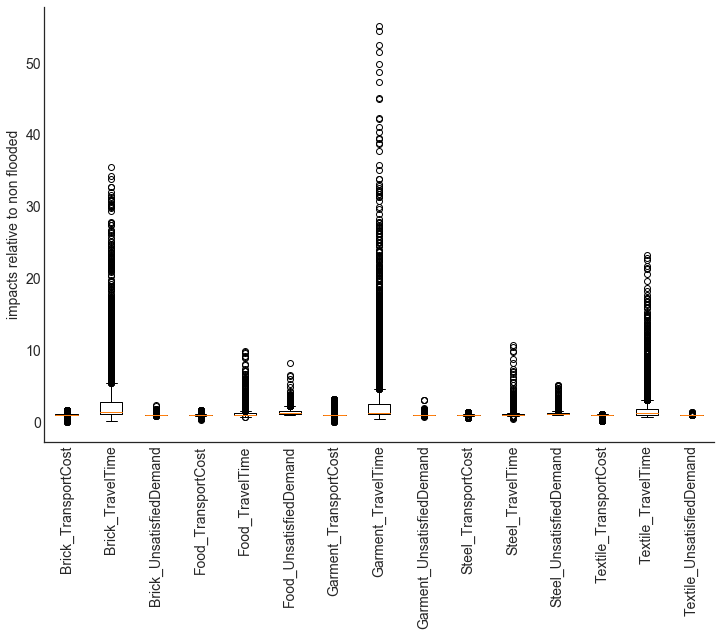

In [3]:
sns.set_style('white')

logical = experiments['policy']=='no intervention'
experiments = experiments[logical]
outcomes = {key:value[logical] for key, value in outcomes.items()}

fig, ax = plt.subplots()
labels, data = zip(*[(key,outcomes[key]) for key in 
                     sorted(outcomes.keys())])
data = [v for k,v in zip(labels, data)]
ax.boxplot(data, labels=labels)
ax.set_ylabel('impacts relative to non flooded')
# ax.set_yscale('log')
plt.xticks(rotation=90)
sns.despine()

change_fontsize(fig, 14)
save_fig(fig, './results/figs/', 'boxplot_no_intervention')

plt.show()

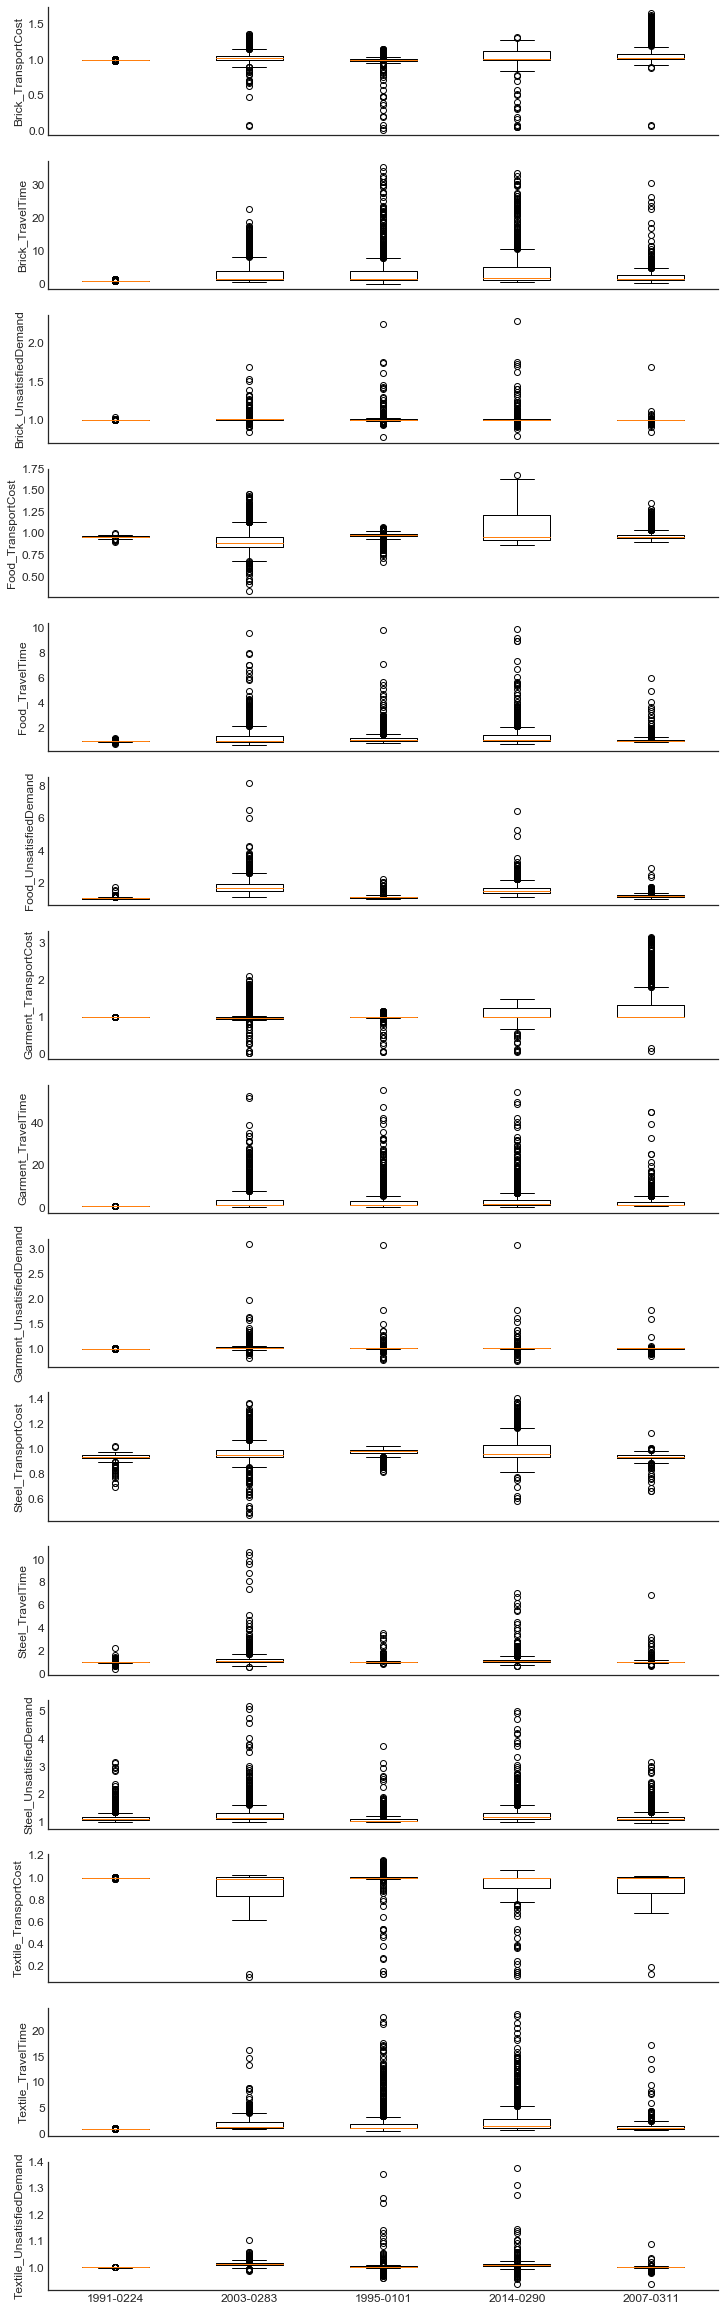

In [14]:
keys = list(outcomes.keys())
keys.sort()

fig, axes = plt.subplots(nrows=len(keys))
fig.set_figheight(42)
for i, key in enumerate(keys):
    value = outcomes[key]
    ax = axes[i]
    
    labels = list(set(experiments['Flood_area']))
    data = []
    for flood_area in labels :
        logical = experiments['Flood_area']==flood_area
        data.append(value[logical])
    
    ax.boxplot(data, labels=labels, vert=True)
    ax.set_ylabel(key)

    if i < len(keys)-1:
        ax.set_xticks([])
    sns.despine()

    change_fontsize(fig, 12)
#     save_fig(fig, './results/figs/', 'boxplot')

plt.show()

In [ ]:
from ema_workbench.analysis.feature_scoring import get_feature_scores_all
remove = ['model', 'scenario_id',  'Intervention_1', 'policy']
filtered_experiments = rcf.drop_fields(experiments, asrecarray=True, 
                                       drop_names=remove)

fs = get_feature_scores_all(filtered_experiments, outcomes)

In [17]:
fs = fs.reindex(['Flood_area', 'Flood_depth', 'Flood_duration',
'Road_cost', 'Trs_cost','Water_cost',
'Damage_bridge_a', 'Damage_bridge_b', 'Damage_bridge_c', 'Damage_bridge_d',
'Damage_ferry', 'Damage_ports', 'Damage_terminals', 
'Damage_railstations', 'Damage_railways',
'Damage_road_n', 'Damage_road_r', 'Damage_road_z', 
'Damage_waterway_1', 'Damage_waterway_2', 'Damage_waterway_3','Damage_waterway_4', 
'Brick_rail', 'Brick_road', 'Brick_water', 
'Food_rail', 'Food_road', 'Food_water', 
'Garment_rail', 'Garment_road', 'Garment_water', 
'Steel_rail', 'Steel_road', 'Steel_water',
'Textile_rail', 'Textile_road', 'Textile_water'])
fs = fs[sorted(fs.columns)]

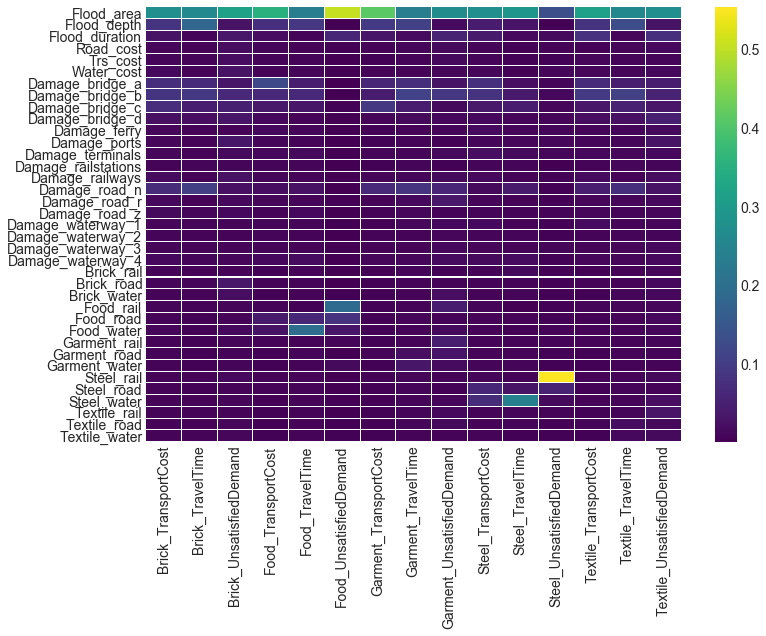

In [18]:
sns.heatmap(fs, cmap='viridis',linewidths=.01)

fig = plt.gcf()
change_fontsize(fig)
save_fig(fig, './results/figs/', '_fs')

plt.show()

I would like to see the correlation of the feature scores by floodmap for each outcome

In [37]:
remove = ['model', 'scenario_id',  'Intervention_1',]
experiments = rcf.drop_fields(experiments, asrecarray=True, 
                                       drop_names=remove)

floodmaps = set(experiments['Flood_area'])
feature_scores = {}
for floodmap in floodmaps:
    logical = experiments['Flood_area']==floodmap
    x = experiments[logical]
    y = {key:value[logical] for key, value in outcomes.items()}
    feature_scores[floodmap] = get_feature_scores_all(x,y).T


In [39]:
feature_scores.keys()

dict_keys(['1991-0224', '2003-0283', '1995-0101', '2014-0290', '2007-0311'])

## measures

/Users/jhkwakkel/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


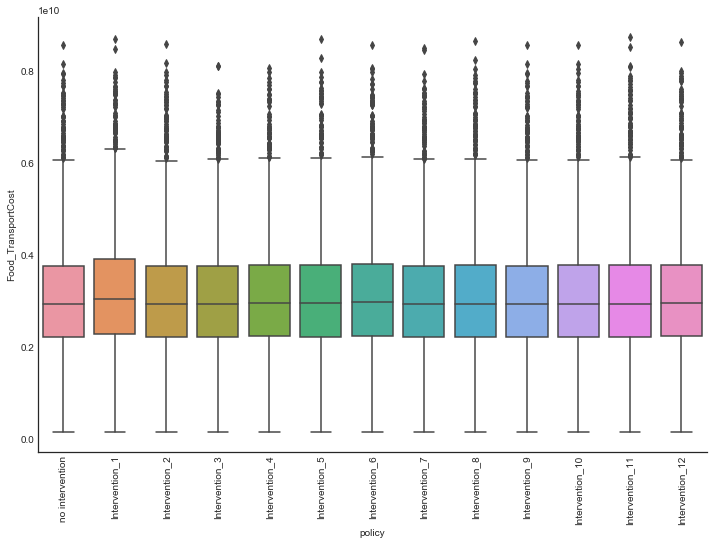

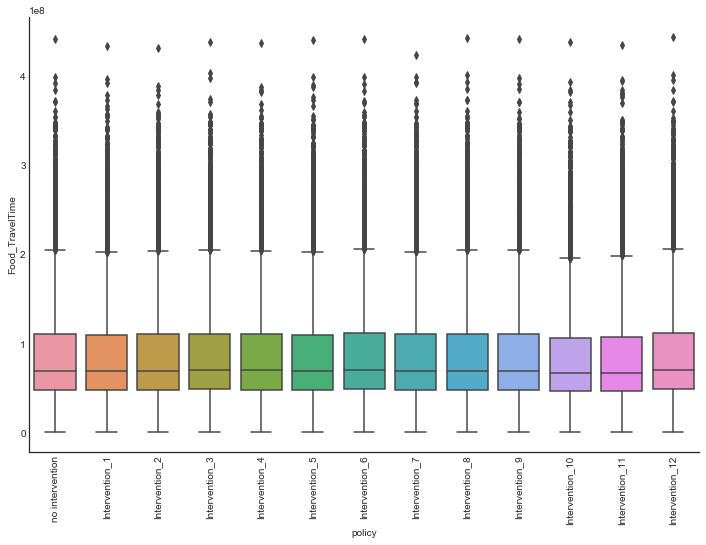

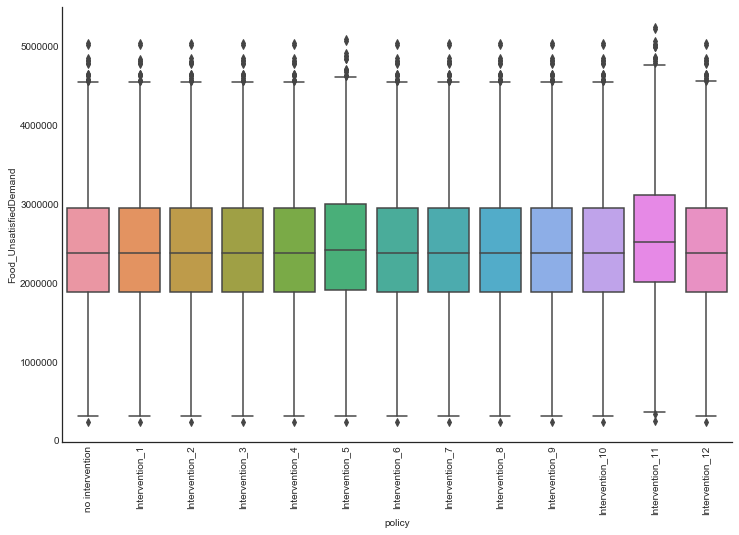

In [53]:
from numpy.lib import recfunctions as rf
import natsort

results = load_results('./results/pff 6 floods 1000 experiments cleaned.tar.gz')
experiments, outcomes = results

policies = experiments['policy']
order = natsort.natsorted(set(policies))
order.remove('no intervention')
order = ['no intervention',] + order

data = pd.DataFrame.from_dict(dict(policy=policies, 
                                   **outcomes))
oois = sorted(list(outcomes.keys()))
for ooi in oois:
    if not ooi.startswith('Food'):
        continue
    
    figure, ax = plt.subplots()
    ax.set_ylabel(ooi)
    sns.boxplot(data=data, x='policy', y=ooi, ax=ax, order=order)
    plt.xticks(rotation=90)
    sns.despine()
plt.show()

what to use in normalization? The no intervention, non flooded case? the no intervenion, flooded case?
the non_flooded but with intervention case?

In [54]:
# have to rebuild scenario index
index = np.zeros(experiments.shape[0], dtype=np.int)

for i, entry in enumerate(set(experiments['Textile_road'])):
    for j, floodmap in enumerate(set(experiments['Flood_area'])):
        logical = (experiments['Textile_road']==entry) & (experiments['Flood_area']==floodmap)
        index[logical] = i + j*1000

data = pd.DataFrame.from_dict(dict(policy=policies, 
                                   scenario_id=index,
                                   **outcomes)).set_index(['scenario_id', 'policy'])
data.head()

,,Brick_TransportCost,Brick_TravelTime,Brick_UnsatisfiedDemand,Food_TransportCost,Food_TravelTime,Food_UnsatisfiedDemand,Garment_TransportCost,Garment_TravelTime,Garment_UnsatisfiedDemand,Steel_TransportCost,Steel_TravelTime,Steel_UnsatisfiedDemand,Textile_TransportCost,Textile_TravelTime,Textile_UnsatisfiedDemand
scenario_id,policy,,,,,,,,,,,,,,,
2321,Intervention_1,1.299184e+09,5.236233e+06,1.608284e+06,2.697916e+09,7.917460e+07,2.567835e+06,1.967334e+08,7.908910e+05,269746.018468,7.752165e+08,1.280518e+07,102497.876756,1.624340e+08,635607.523659,153728.891932
2451,Intervention_1,1.588184e+09,6.087068e+06,1.493762e+06,3.426168e+09,7.561719e+07,1.836585e+06,2.498055e+08,9.695188e+05,239185.020607,6.956009e+08,1.635580e+07,150561.529540,6.615866e+07,324659.832918,187295.683631
2170,Intervention_1,1.814680e+09,8.445611e+06,1.183973e+06,4.138630e+09,1.299078e+08,1.502796e+06,2.103675e+08,1.083488e+06,236237.287918,9.213092e+08,4.473408e+07,152995.251198,2.164305e+08,941115.363589,121817.013636
2107,Intervention_1,7.693311e+08,5.492141e+06,1.570717e+06,2.161941e+09,7.069311e+07,2.302643e+06,2.335956e+08,1.458698e+06,119537.823809,7.133989e+08,2.511375e+07,52456.492148,8.711900e+07,662506.425276,156014.423268
2512,Intervention_1,7.362432e+08,2.982505e+06,1.918693e+06,1.853952e+09,8.181774e+07,2.788714e+06,2.282407e+08,9.757408e+05,258599.747916,4.843352e+08,1.790676e+07,247634.362952,1.034724e+08,536401.865348,175246.538967


In [55]:
normalization = data.xs('no intervention', level=1)
grouped = data.groupby('policy')
normalized = grouped.apply(lambda x: x/normalization)


/Users/jhkwakkel/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


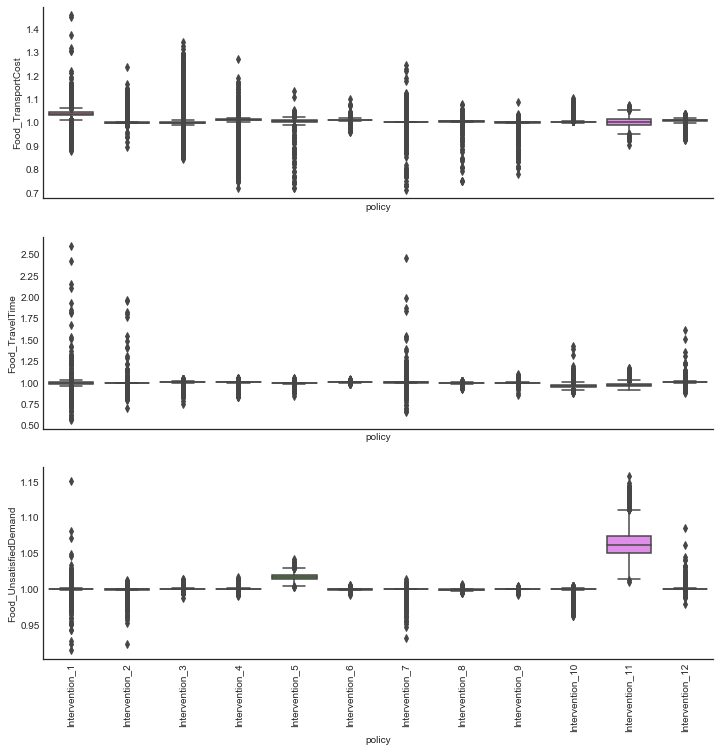

In [65]:
data = normalized.reset_index(level='policy')
fig, axes = plt.subplots(nrows=3)
fig.set_size_inches(12, 12)

oois = [ooi for ooi in oois if ooi.startswith('Food')]

for i, ooi in enumerate(oois):
    ax = axes[i]
    ax.set_ylabel(ooi)
    sns.boxplot(data=data, x='policy', y=ooi, ax=ax, order=order)
plt.xticks(rotation=90)

ax1, ax2, ax3 = axes
ax1.set_xticks([])
ax2.set_xticks([])

sns.despine()
save_fig(plt.gcf(), './results/figs/', '_food')
plt.show()

/Users/jhkwakkel/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


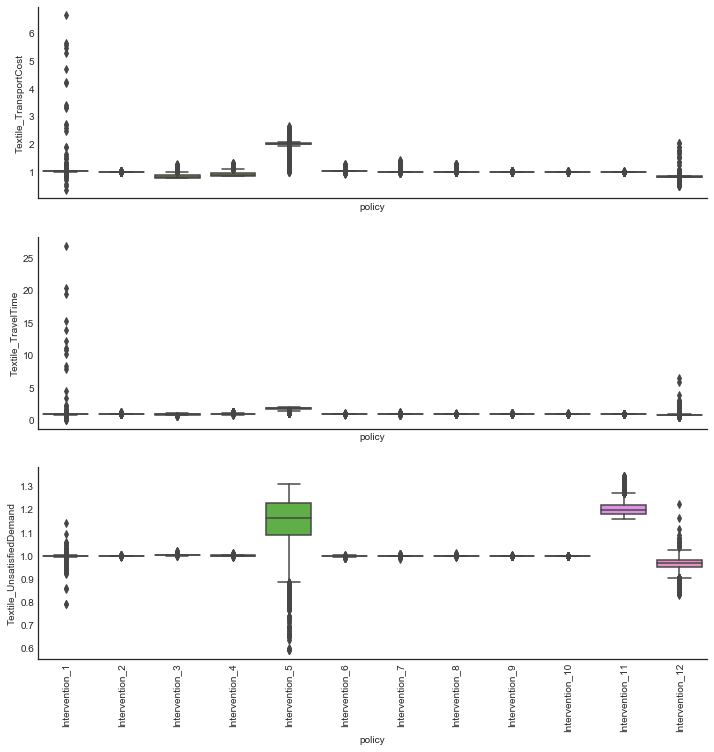

In [68]:
data = normalized.reset_index(level='policy')
fig, axes = plt.subplots(nrows=3)
fig.set_size_inches(12, 12)
oois = outcomes.keys()
oois = [ooi for ooi in oois if ooi.startswith('Textile')]
oois = natsort.natsorted(oois)

for i, ooi in enumerate(oois):
    ax = axes[i]
    ax.set_ylabel(ooi)
    sns.boxplot(data=data, x='policy', y=ooi, ax=ax, order=order)
plt.xticks(rotation=90)

ax1, ax2, ax3 = axes
ax1.set_xticks([])
ax2.set_xticks([])

sns.despine()
save_fig(plt.gcf(), './results/figs/', '_textile')
plt.show()

In [69]:
# have to rebuild scenario index
index = np.zeros(experiments.shape[0], dtype=np.int)

for i, entry in enumerate(set(experiments['Textile_road'])):
    logical = (experiments['Textile_road']==entry)
    index[logical] = i

data = pd.DataFrame.from_dict(dict(policy=policies, 
                                   scenario_id=index,
                                   floodarea = experiments['Flood_area'],
                                   **outcomes)).set_index(['scenario_id', 'policy', 'floodarea'])
data.head()

,,,Brick_TransportCost,Brick_TravelTime,Brick_UnsatisfiedDemand,Food_TransportCost,Food_TravelTime,Food_UnsatisfiedDemand,Garment_TransportCost,Garment_TravelTime,Garment_UnsatisfiedDemand,Steel_TransportCost,Steel_TravelTime,Steel_UnsatisfiedDemand,Textile_TransportCost,Textile_TravelTime,Textile_UnsatisfiedDemand
scenario_id,policy,floodarea,,,,,,,,,,,,,,,
321,Intervention_1,NON_FLOODED,1.299184e+09,5.236233e+06,1.608284e+06,2.697916e+09,7.917460e+07,2.567835e+06,1.967334e+08,7.908910e+05,269746.018468,7.752165e+08,1.280518e+07,102497.876756,1.624340e+08,635607.523659,153728.891932
451,Intervention_1,NON_FLOODED,1.588184e+09,6.087068e+06,1.493762e+06,3.426168e+09,7.561719e+07,1.836585e+06,2.498055e+08,9.695188e+05,239185.020607,6.956009e+08,1.635580e+07,150561.529540,6.615866e+07,324659.832918,187295.683631
170,Intervention_1,NON_FLOODED,1.814680e+09,8.445611e+06,1.183973e+06,4.138630e+09,1.299078e+08,1.502796e+06,2.103675e+08,1.083488e+06,236237.287918,9.213092e+08,4.473408e+07,152995.251198,2.164305e+08,941115.363589,121817.013636
107,Intervention_1,NON_FLOODED,7.693311e+08,5.492141e+06,1.570717e+06,2.161941e+09,7.069311e+07,2.302643e+06,2.335956e+08,1.458698e+06,119537.823809,7.133989e+08,2.511375e+07,52456.492148,8.711900e+07,662506.425276,156014.423268
512,Intervention_1,NON_FLOODED,7.362432e+08,2.982505e+06,1.918693e+06,1.853952e+09,8.181774e+07,2.788714e+06,2.282407e+08,9.757408e+05,258599.747916,4.843352e+08,1.790676e+07,247634.362952,1.034724e+08,536401.865348,175246.538967


In [70]:
normalization = data.xs(('no intervention', 'NON_FLOODED'), level=(1, 2))
grouped = data.groupby(['policy', 'floodarea'])
normalized = grouped.apply(lambda x: x/normalization)



/Users/jhkwakkel/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


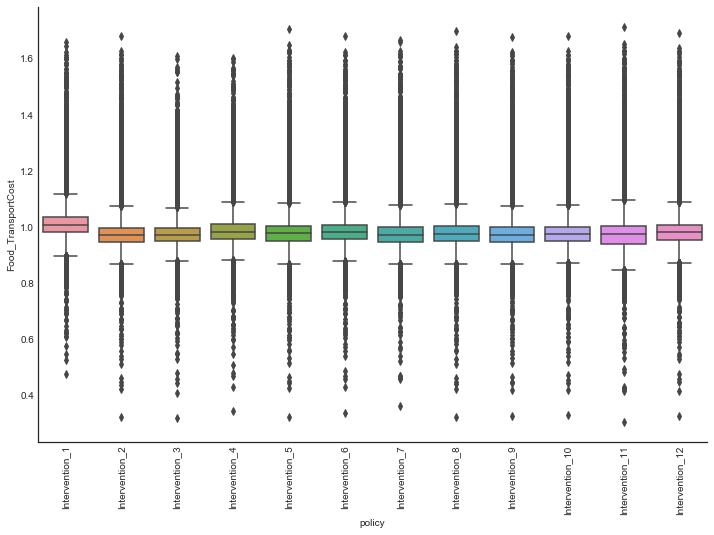

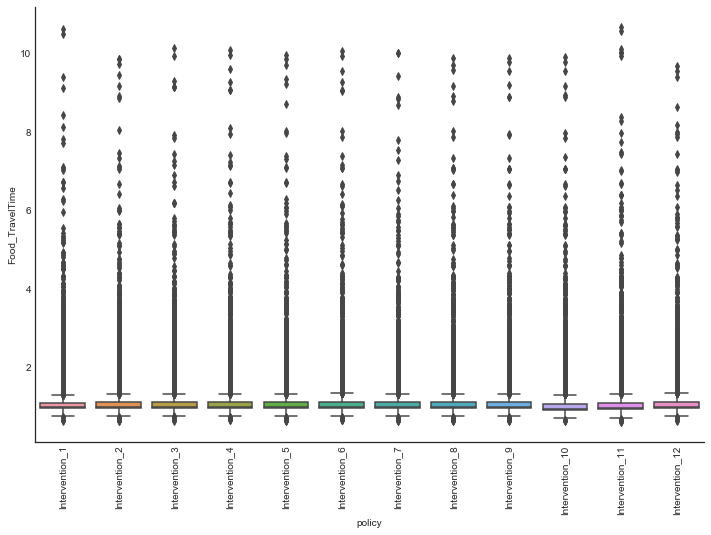

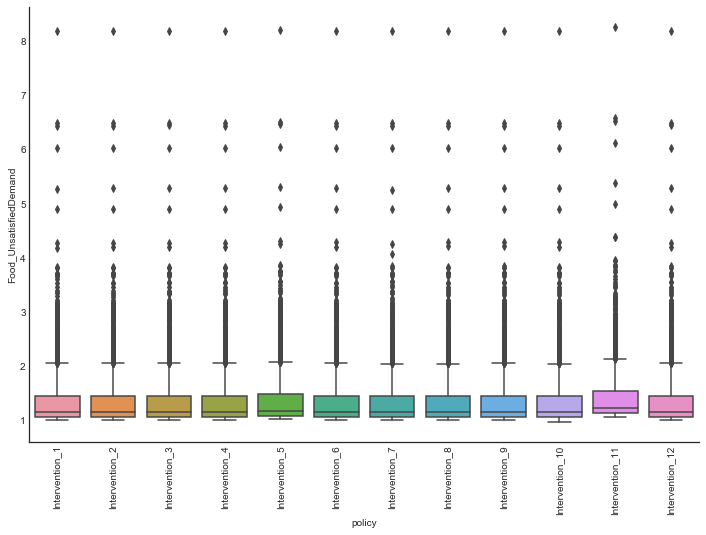

In [72]:
data = normalized.reset_index(level=('policy', 'floodarea'))
oois = list(outcomes.keys())
oois = natsort.natsorted(oois)

for ooi in oois:
    if not ooi.startswith('Food'):
        continue
    
    figure, ax = plt.subplots()
    ax.set_ylabel(ooi)
    sns.boxplot(data=data, x='policy', y=ooi, ax=ax, order=order)
    plt.xticks(rotation=90)
    sns.despine()
plt.show()

## feature scoring

In [78]:
experiments, outcomes = load_results('./results/pff 6 floods 1000 experiments cleaned.tar.gz')

experiments = rf.drop_fields(experiments, asrecarray=True, drop_names=['model'])

fs = get_feature_scores_all(experiments, outcomes)
fs = fs[sorted(fs.columns)]

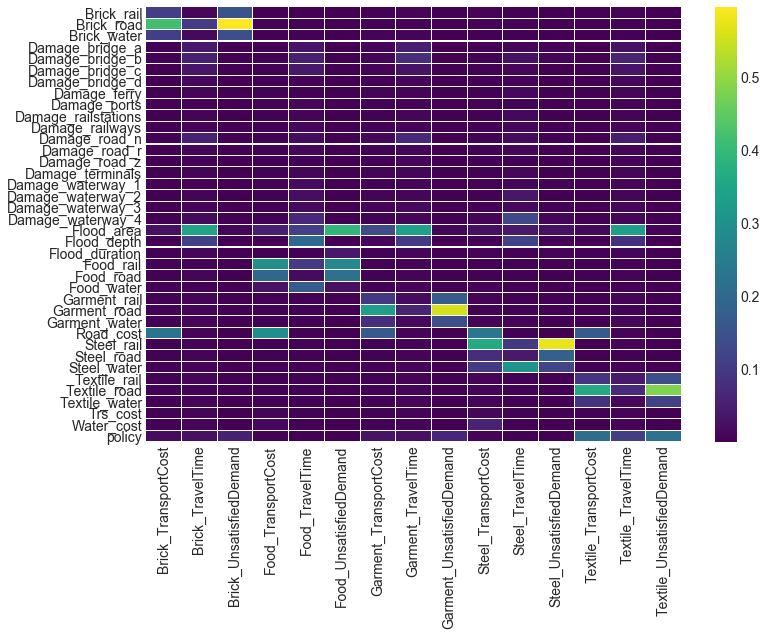

In [81]:
fs
sns.heatmap(fs, cmap='viridis',linewidths=.01)

fig = plt.gcf()
change_fontsize(fig)
save_fig(fig, './results/figs/', '_fs_policies')

plt.show()

## scenario discovery

using normalized data compared to non intervention non flooded, focused on food unsatisfied demand

In [82]:
from ema_workbench import ema_logging
from ema_workbench.analysis import prim

ema_logging.log_to_stderr(ema_logging.INFO)

x = experiments
y = normalized.Food_UnsatisfiedDemand > 1.25

prim_obj = prim.Prim(x,y, threshold=0.8)
box1 = prim_obj.find_box()

[MainProcess/INFO] 78000 points remaining, containing 30168 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.22033333333333333, coverage: 0.5696764783876955, density: 1.0 restricted_dimensions: 3


In [91]:
%matplotlib notebook

<IPython.core.display.Javascript object>


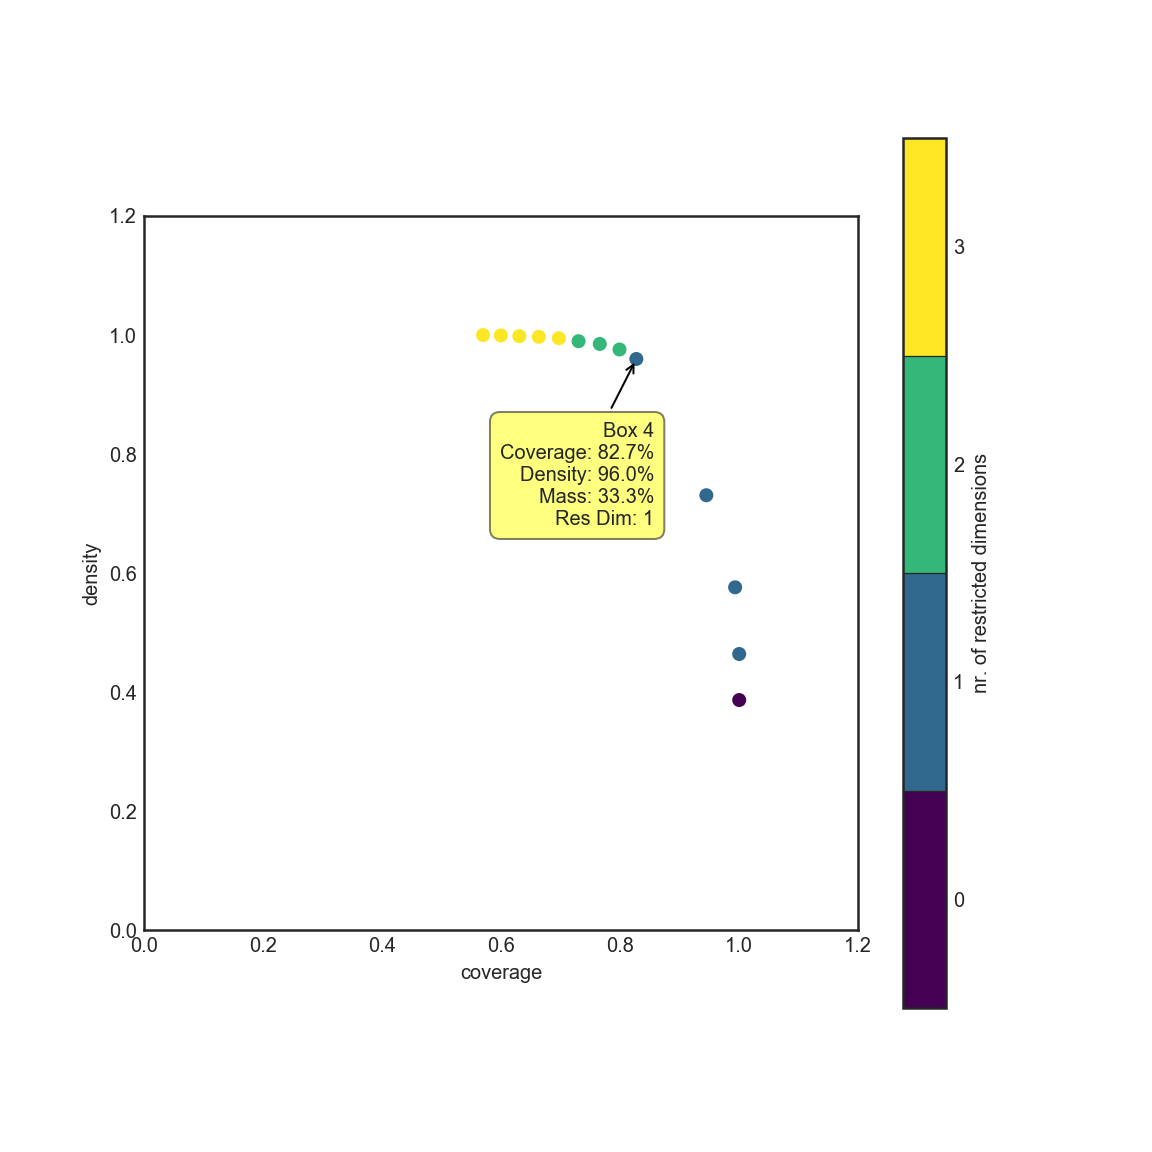

In [92]:
box1.show_tradeoff()
plt.show()

In [93]:
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12,8)

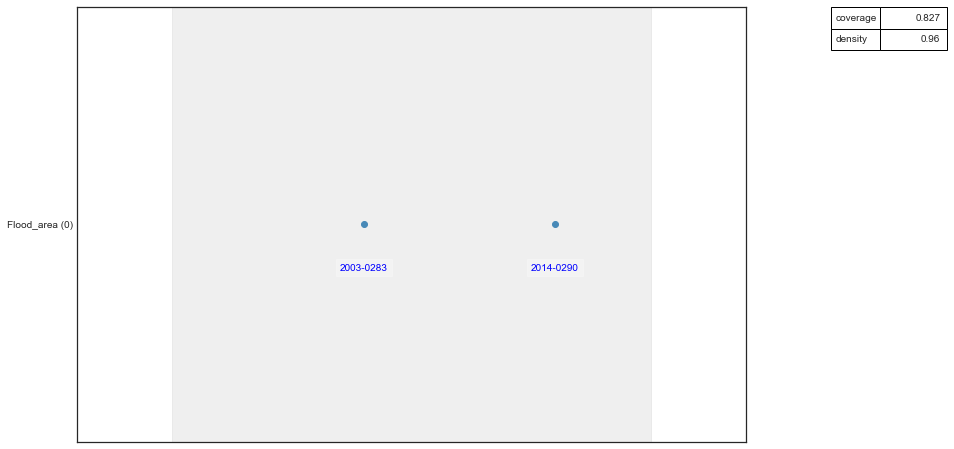

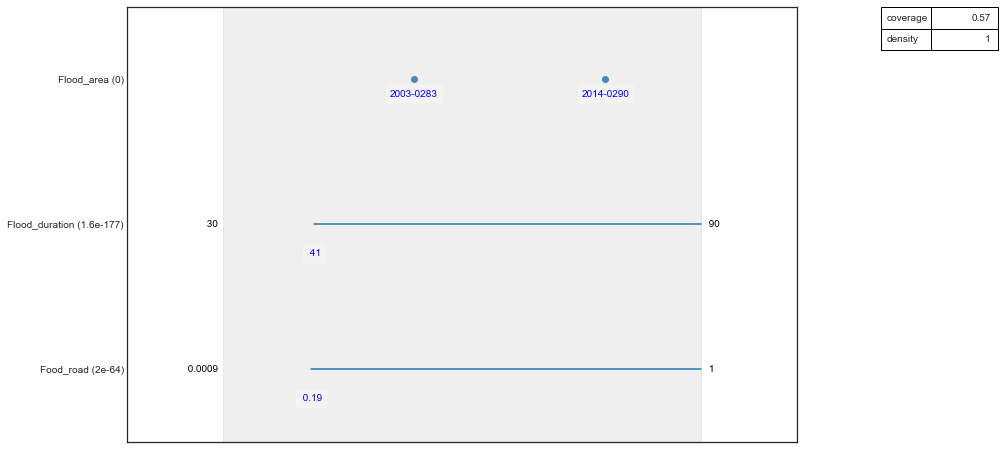

In [97]:
box1.inspect(4, style='graph')
box1.inspect(style='graph')
plt.show()

## scenario discovery without flood maps
let's focus on the 2 worst case flood maps identified previously


TODO:: get_ipython().magic('matplotlib inline')

In [111]:
x = experiments

logical = (experiments['Flood_area'] == '2003-0283') | (experiments['Flood_area'] == '2014-0290')
x = experiments[logical]
x = rf.drop_fields(x, asrecarray=True, drop_names='Flood_area')
y = normalized[logical].Food_UnsatisfiedDemand > 1.75
prim_obj = prim.Prim(x,y, threshold=0.6)
box1 = prim_obj.find_box()

[MainProcess/INFO] 26000 points remaining, containing 8677 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.096, coverage: 0.2876570243171603, density: 1.0 restricted_dimensions: 6


In [119]:
toggle_notebook()

<IPython.core.display.Javascript object>


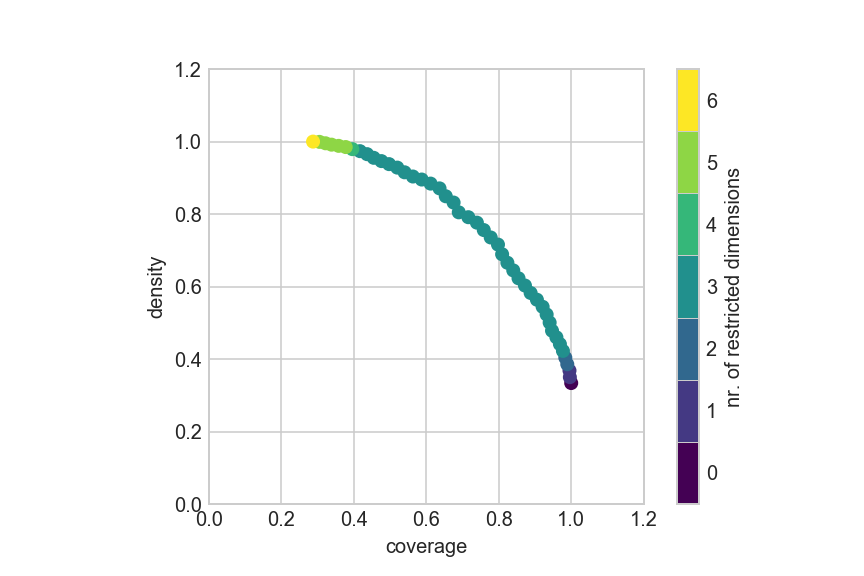

In [122]:
plt.rcParams['nbagg.transparent']= True
plt.rcParams['savefig.facecolor']='white'
box1.show_tradeoff()
plt.show()

In [124]:
toggle_inline()

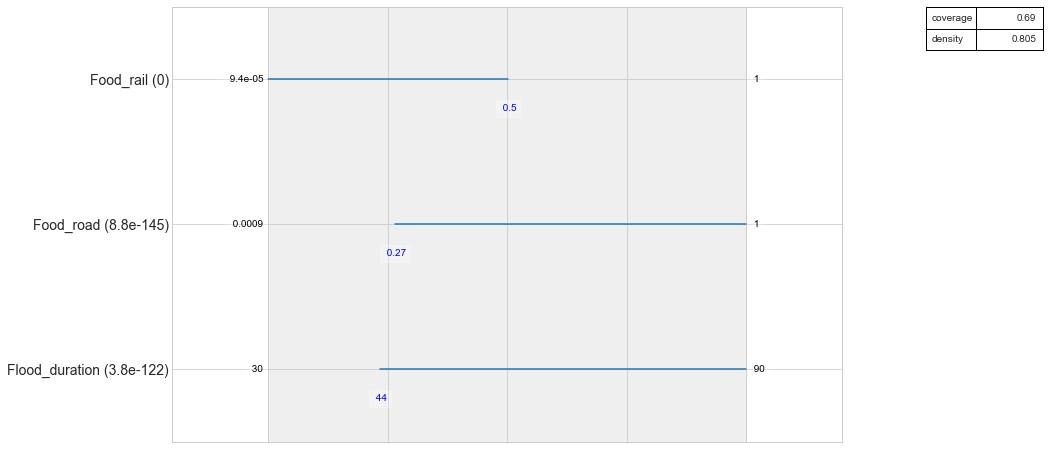

In [126]:
box1.inspect(24, style='graph')
change_fontsize(plt.gcf())
save_fig(plt.gcf(), './results/figs/', '_prim')
# box1.inspect(36, style='graph')
# change_fontsize(plt.gcf())
# box1.inspect(style='graph')
# change_fontsize(plt.gcf())
plt.show()

## regret based analysis

let's use reference case regret to futher explore the results

In [211]:
experiments, outcomes = load_results('./results/pff 6 floods 1000 experiments cleaned.tar.gz')

[MainProcess/INFO] results loaded succesfully from /Users/jhkwakkel/Documents/bangladesh_roadtransport/simulation_model/results/pff 6 floods 1000 experiments cleaned.tar.gz


In [212]:

mapping = {'Intervention_1': '01 Dhaka Chittagong highway expansion',
           'Intervention_2': '02 R504',
           'Intervention_3': '03 1st Padma bridge',
           'Intervention_4': '04 2nd Padma bridge',
           'Intervention_5': '05 South Asia connectivity project',
           'Intervention_6': '06 Dhaka bypass',
           'Intervention_7': '07 Eastern Bangladesh bridge improvement',
           'Intervention_8': '08 Bangabandhu Bridge on N405',
           'Intervention_9': '09 improving high criticality regional roads',
           'Intervention_10': '10 Waterway capacity increase',
           'Intervention_11': '11 Chittagong port development',
           'Intervention_12': '12 Mongla port development',
            }

for key, value in mapping.items():
    index = np.where(experiments['policy']==key)

    # for some silly reason we cannot vectorize over policy column
    # probably because dtype is object or something similar
    for entry in index:
        experiments['policy'][entry] = value

['01 Dhaka Chittagong highway expansion'
 '01 Dhaka Chittagong highway expansion'
 '01 Dhaka Chittagong highway expansion' ...,
 '01 Dhaka Chittagong highway expansion'
 '01 Dhaka Chittagong highway expansion'
 '01 Dhaka Chittagong highway expansion']
['02 R504' '02 R504' '02 R504' ..., '02 R504' '02 R504' '02 R504']
['03 1st Padma bridge' '03 1st Padma bridge' '03 1st Padma bridge' ...,
 '03 1st Padma bridge' '03 1st Padma bridge' '03 1st Padma bridge']
['04 2nd Padma bridge' '04 2nd Padma bridge' '04 2nd Padma bridge' ...,
 '04 2nd Padma bridge' '04 2nd Padma bridge' '04 2nd Padma bridge']
['05 South Asia connectivity project' '05 South Asia connectivity project'
 '05 South Asia connectivity project' ...,
 '05 South Asia connectivity project' '05 South Asia connectivity project'
 '05 South Asia connectivity project']
['06 Dhaka bypass' '06 Dhaka bypass' '06 Dhaka bypass' ...,
 '06 Dhaka bypass' '06 Dhaka bypass' '06 Dhaka bypass']
['07 Eastern Bangladesh bridge improvement'
 '07 East

In [213]:
# have to rebuild scenario index

index = np.zeros(experiments.shape[0], dtype=np.int)

for i, entry in enumerate(set(experiments['Textile_road'])):
    for j, floodmap in enumerate(set(experiments['Flood_area'])):
        logical = (experiments['Textile_road']==entry) & (experiments['Flood_area']==floodmap)
        index[logical] = i + j*1000

data = pd.DataFrame.from_dict(dict(policy=experiments['policy'], 
                                   scenario_id=index,
                                   **outcomes)).set_index(['scenario_id', 'policy'])
normalization = data.xs(('no intervention'), level=1)
grouped = data.groupby(['policy'])
reference_regret = grouped.apply(lambda x: x-normalization)

/Users/jhkwakkel/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


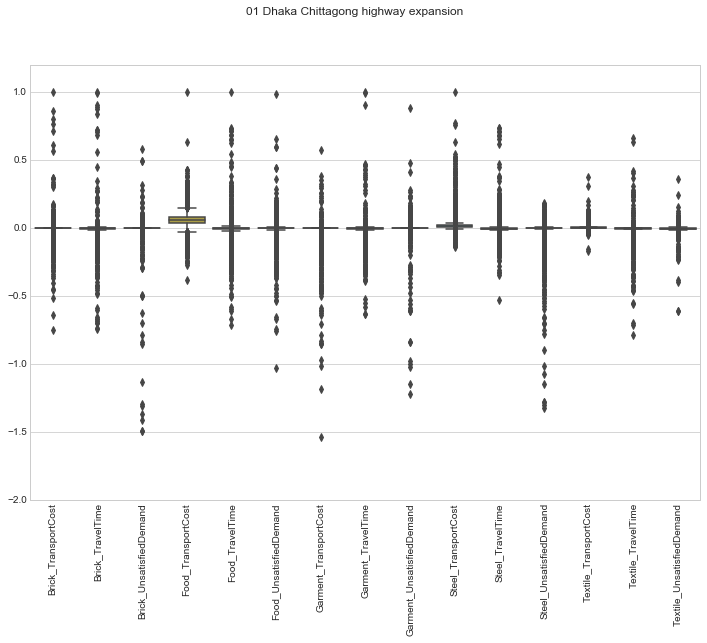

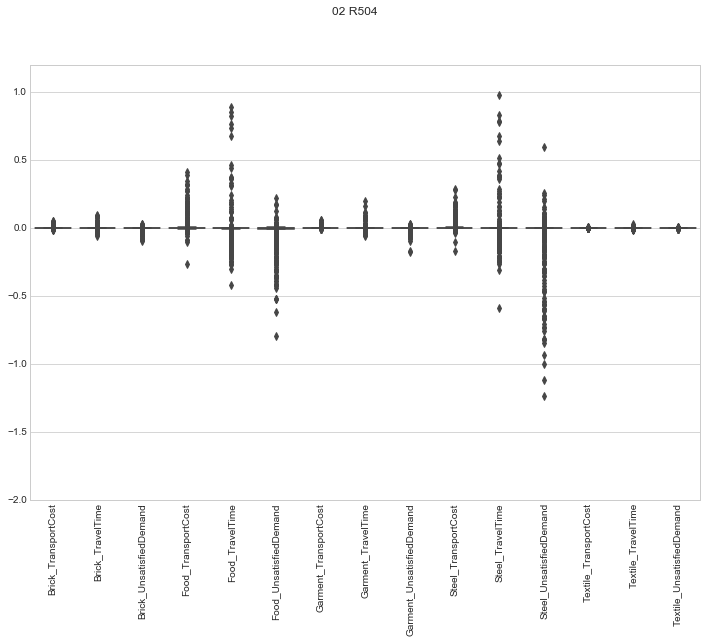

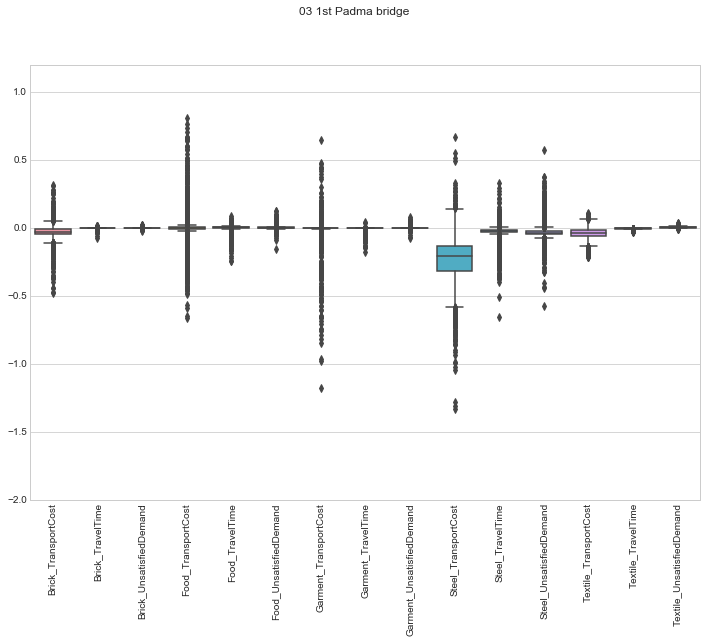

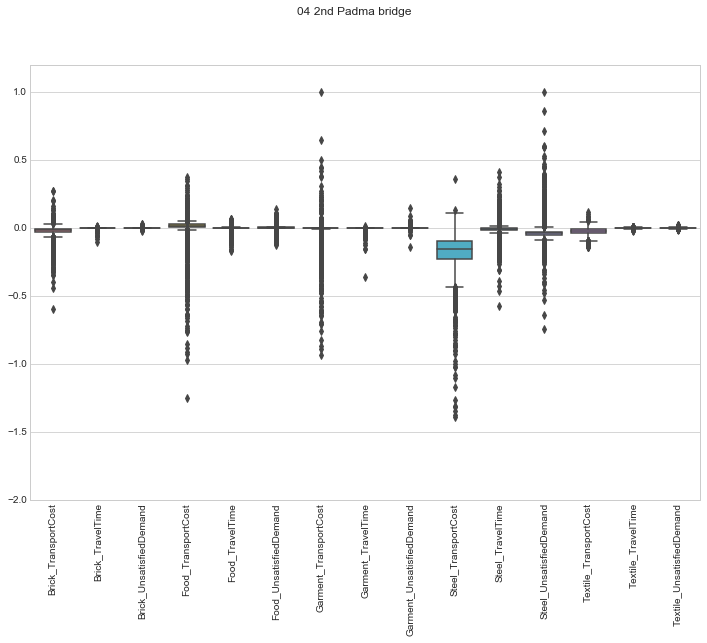

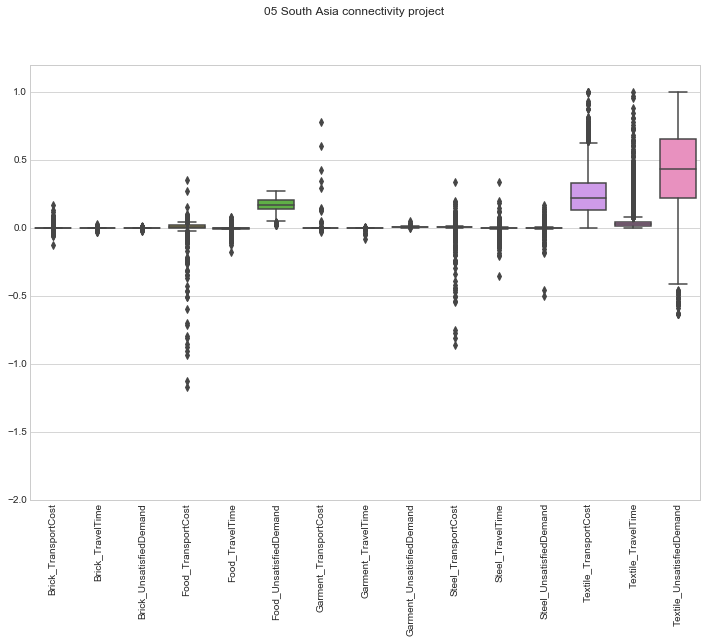

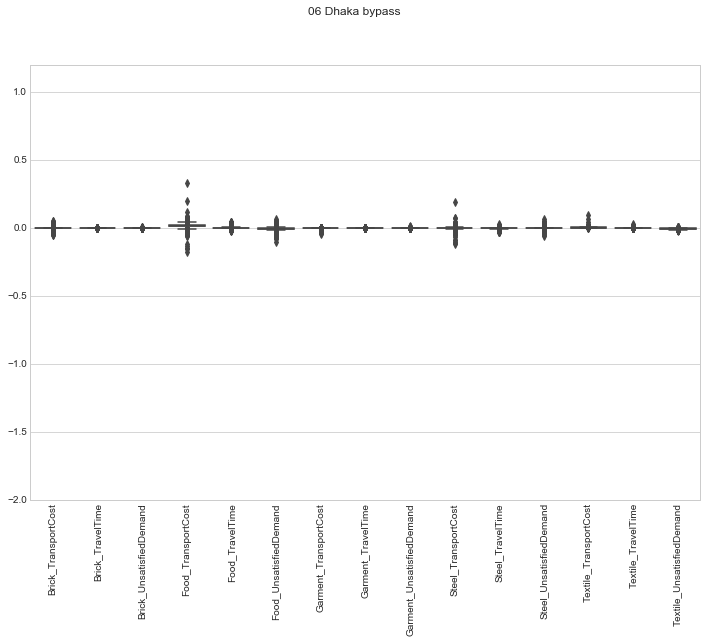

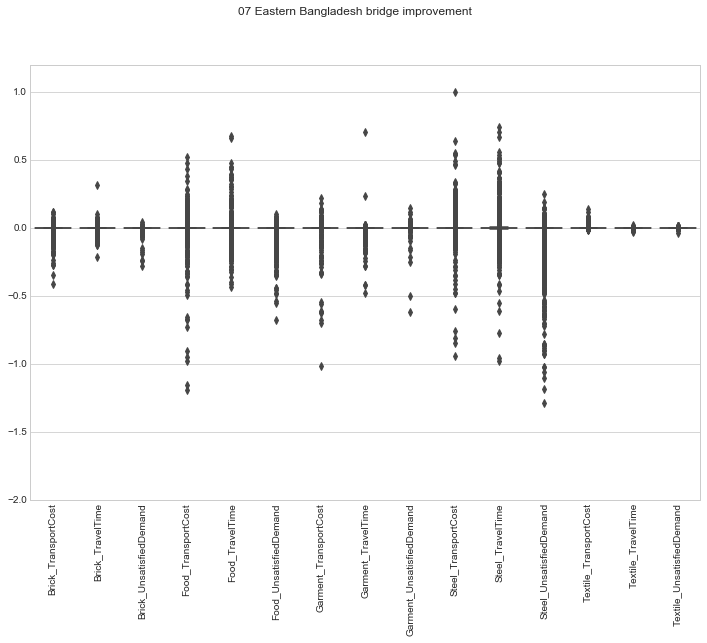

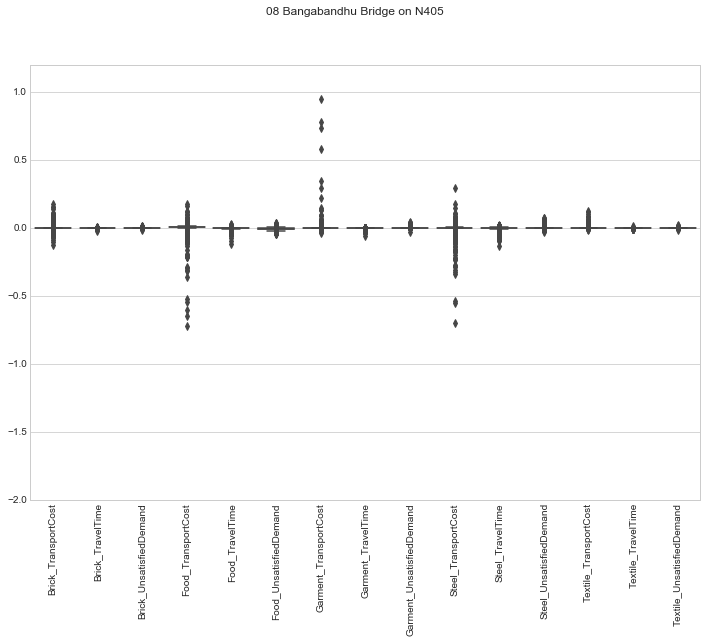

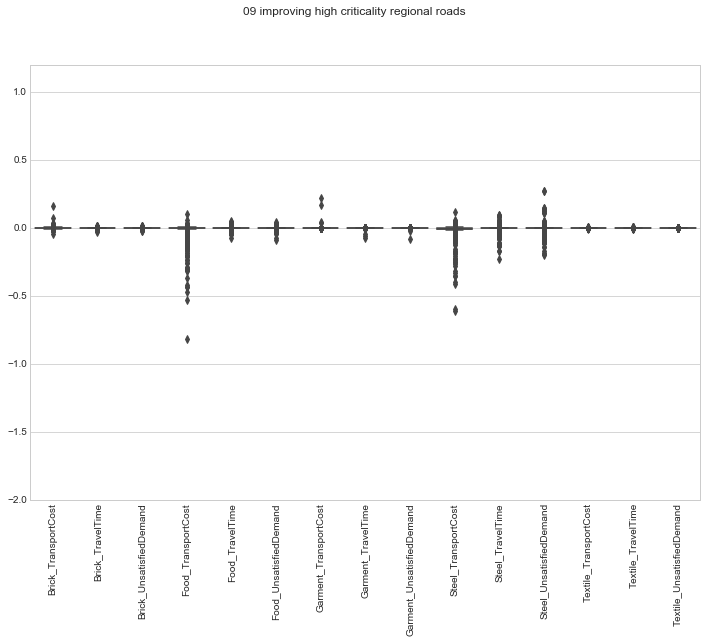

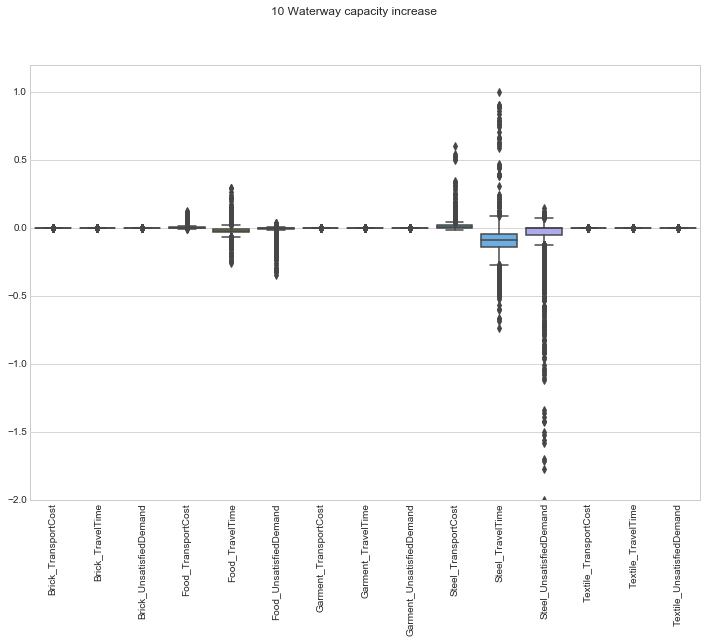

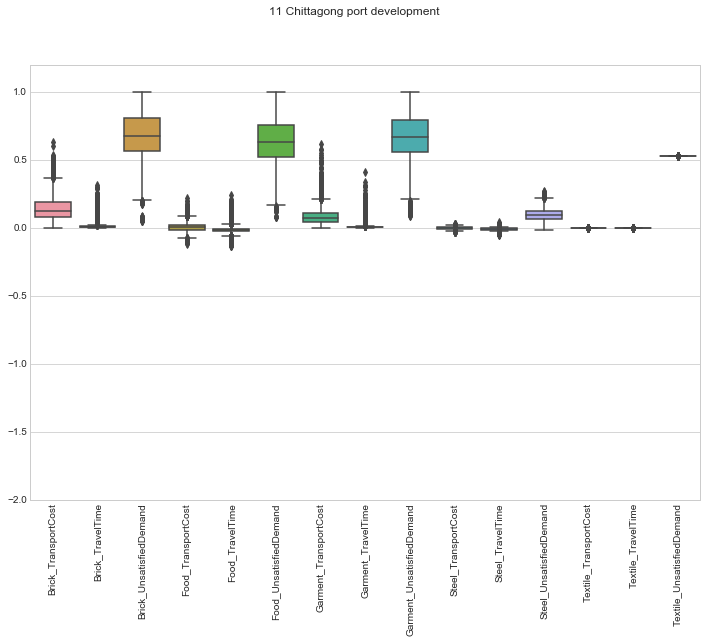

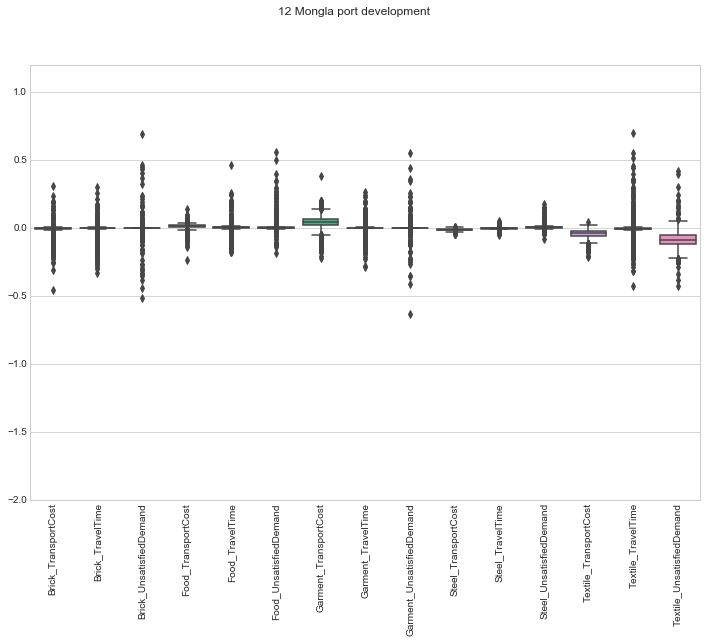

In [217]:
plotdata = reference_regret.copy()
policies = set(experiments['policy'])
policies.remove('no intervention')
policies = natsort.natsorted(policies)

maxima = plotdata.max()

plotdata = plotdata[sorted(plotdata.columns)]

for policy in policies:
    data = plotdata.xs(policy, level=1)
    fig, ax = plt.subplots()
    fig.suptitle(policy)
    data = data/maxima
    sns.boxplot(data=data, ax=ax)
    plt.xticks(rotation=90)
    ax.set_ylim(ymin=-2, ymax=1.2)
    plt.show()

/Users/jhkwakkel/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


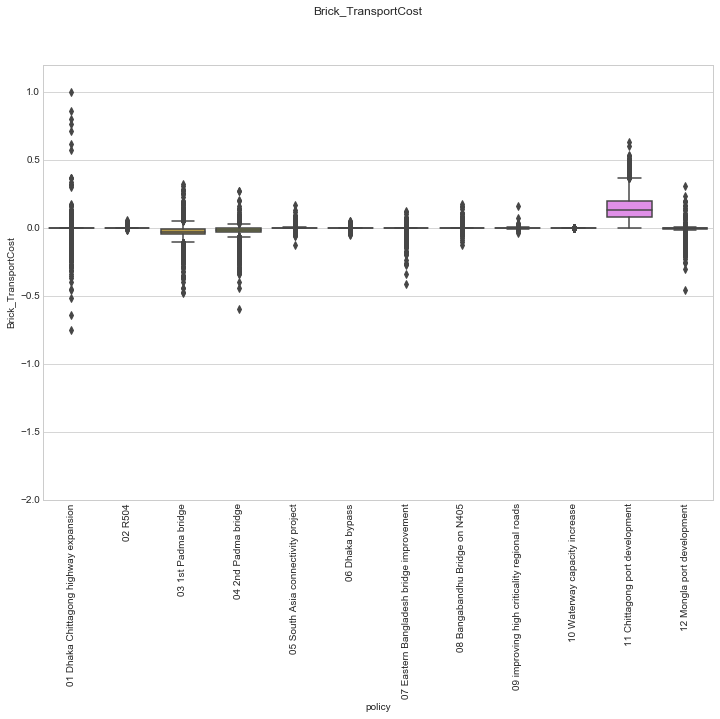

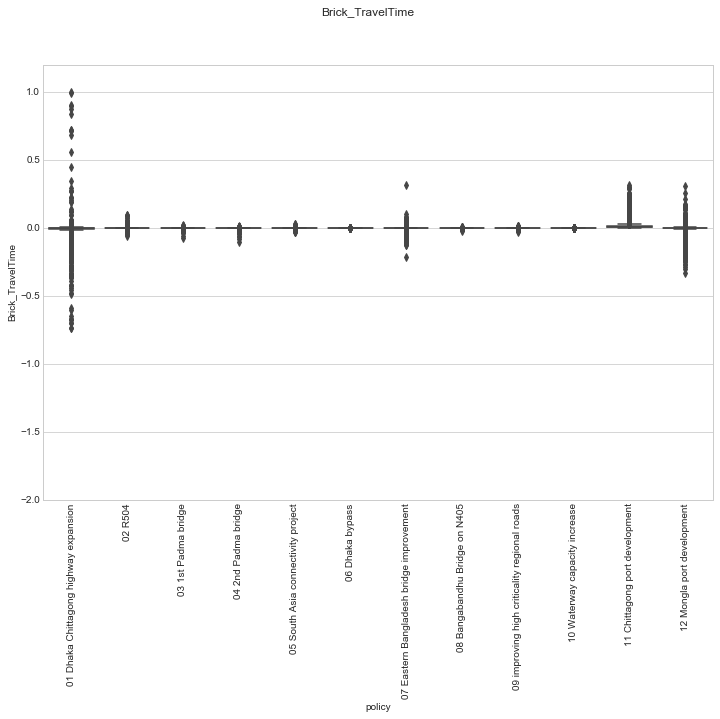

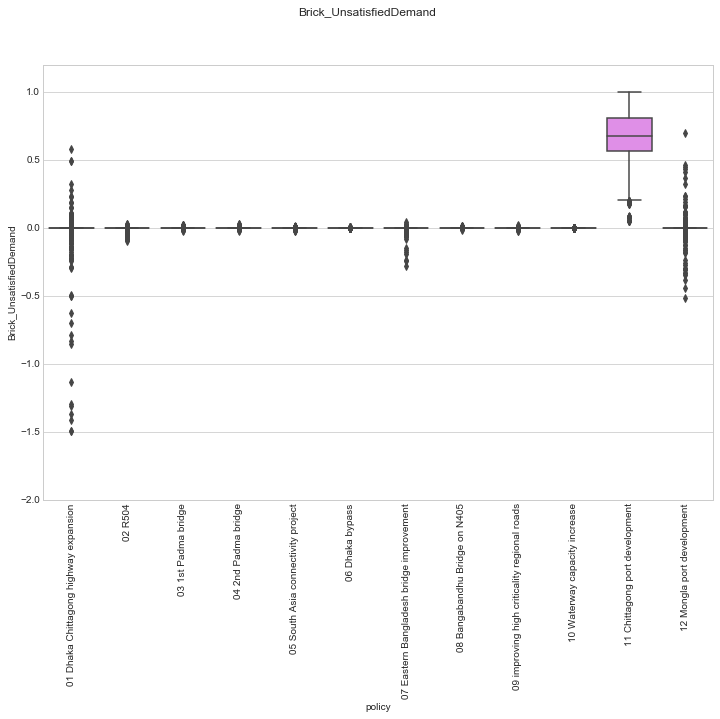

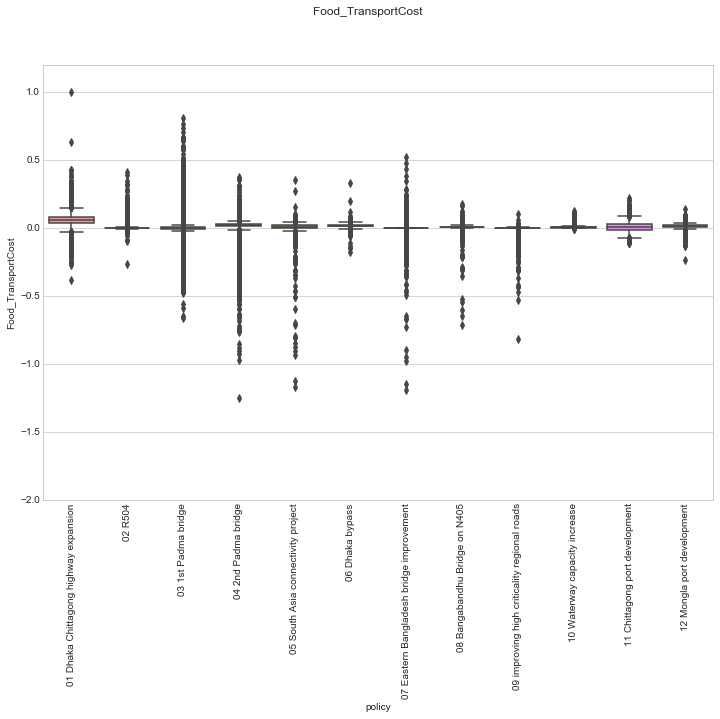

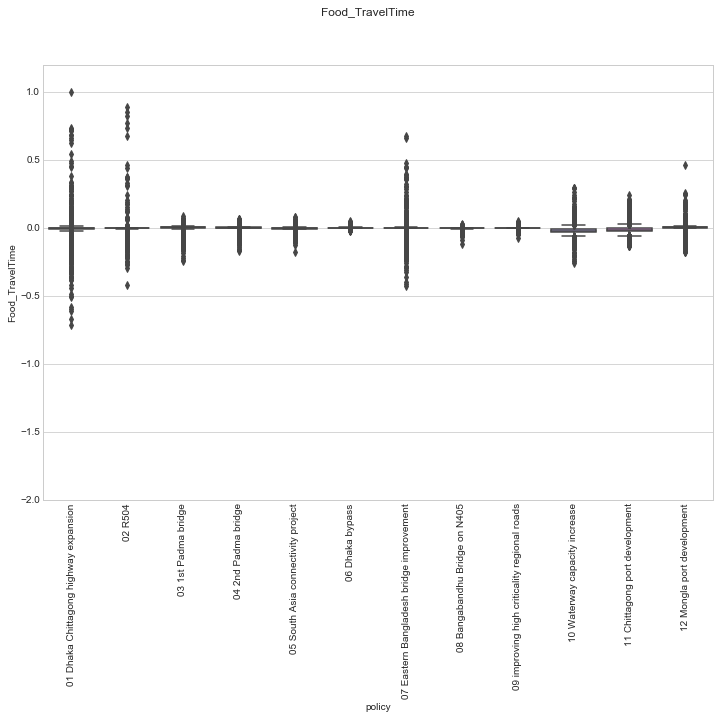

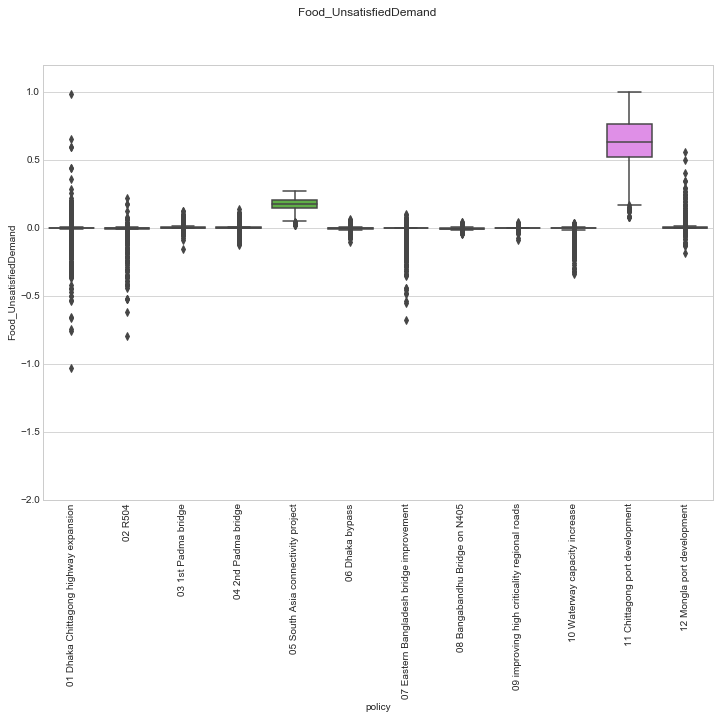

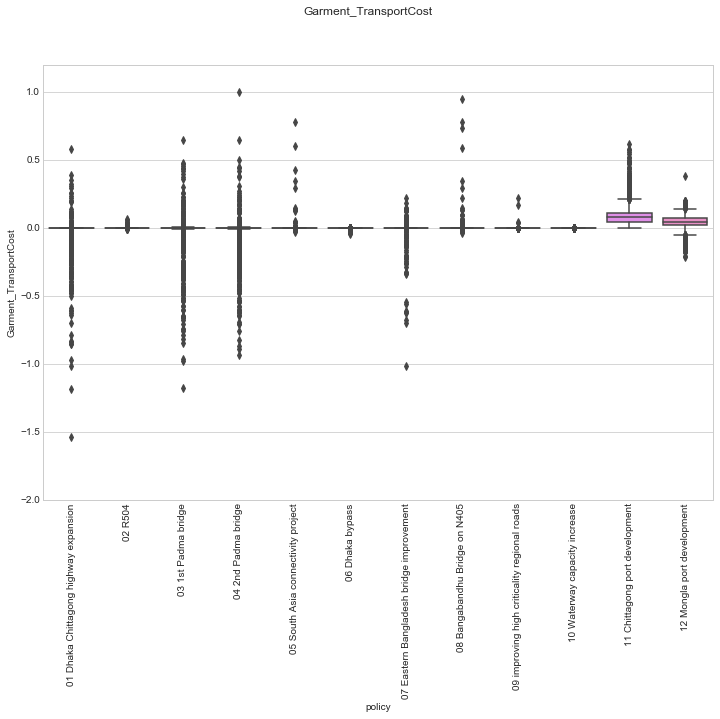

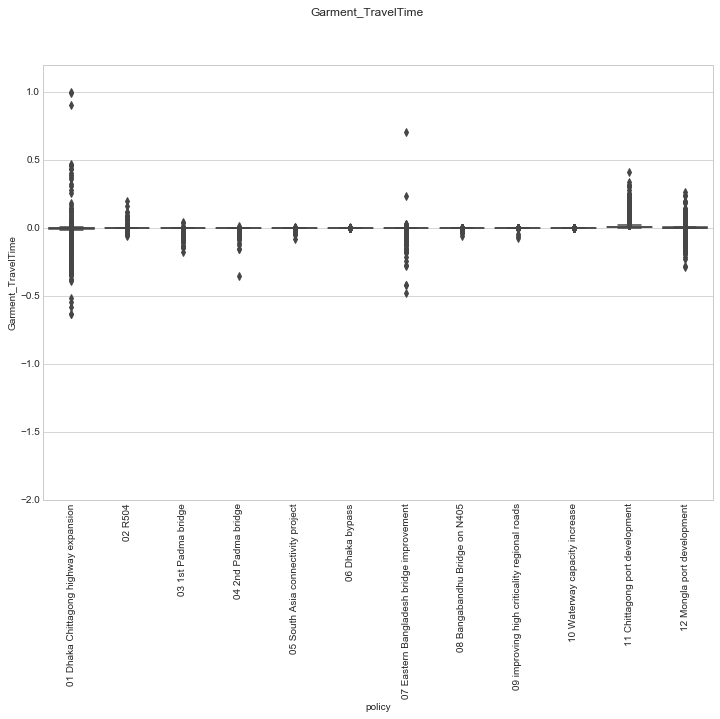

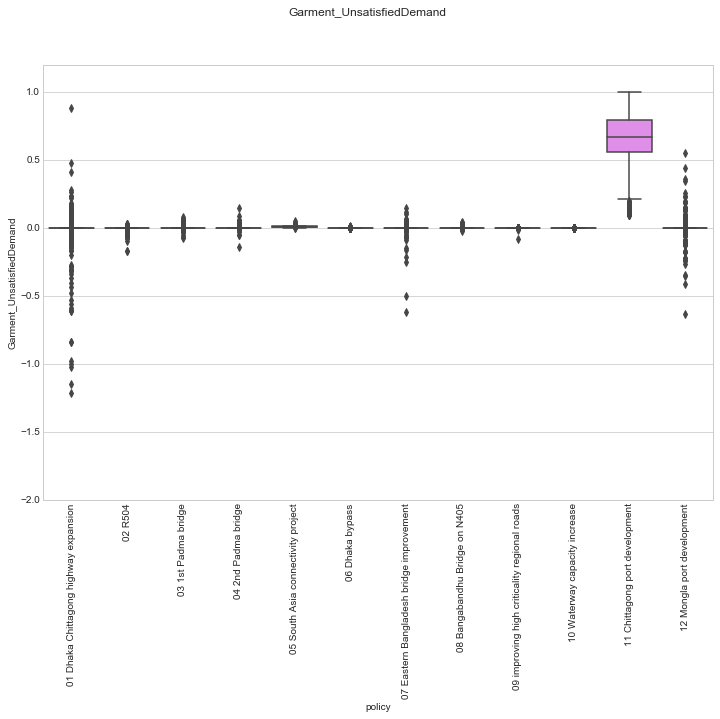

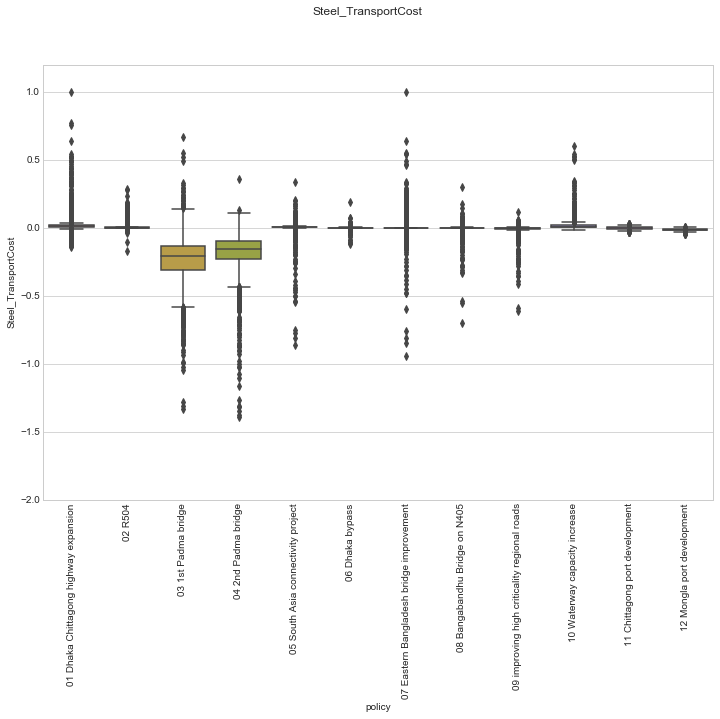

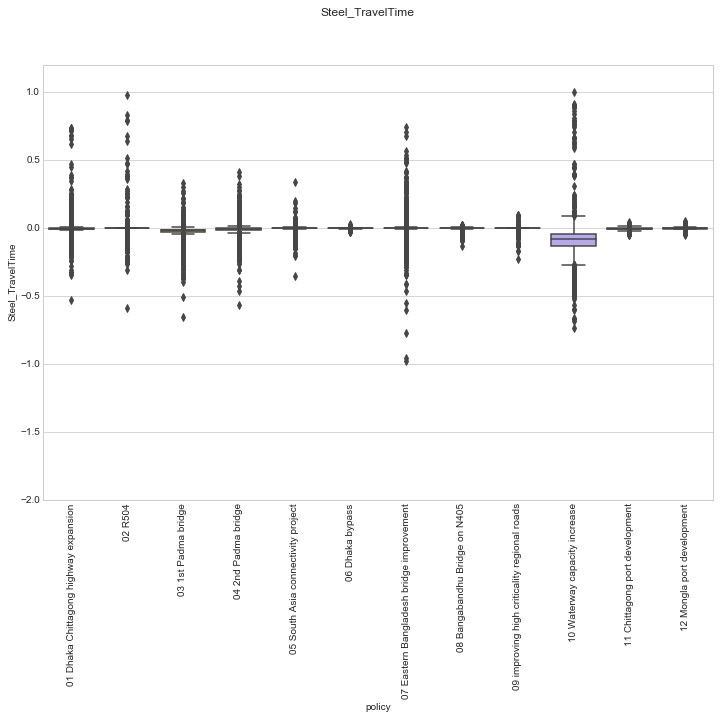

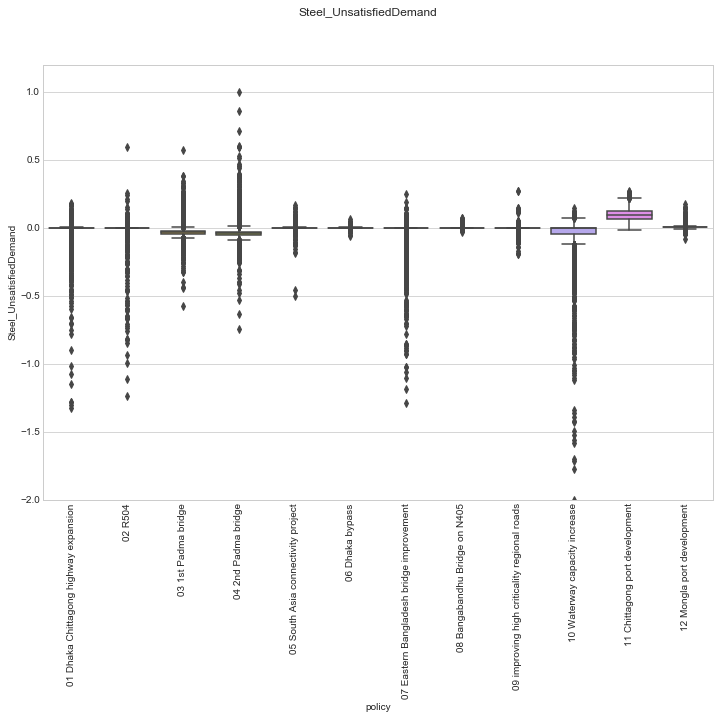

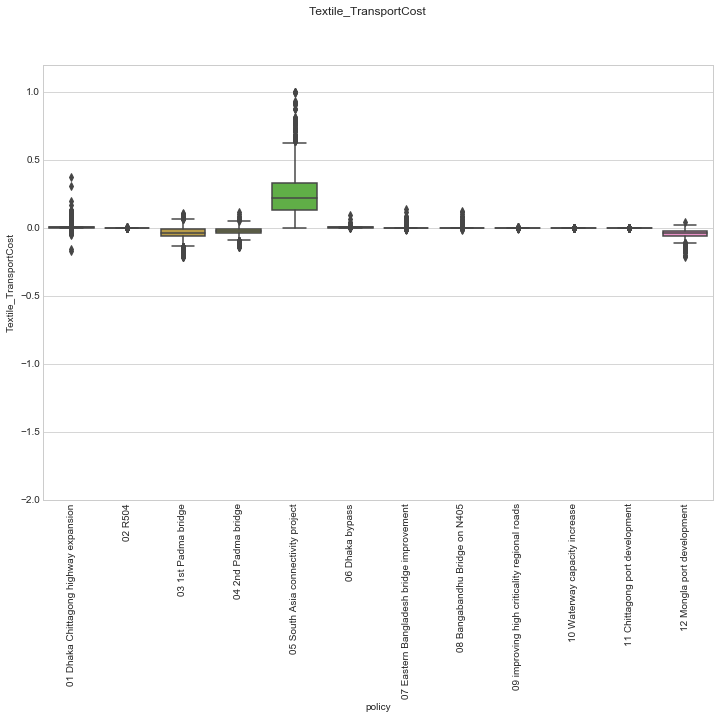

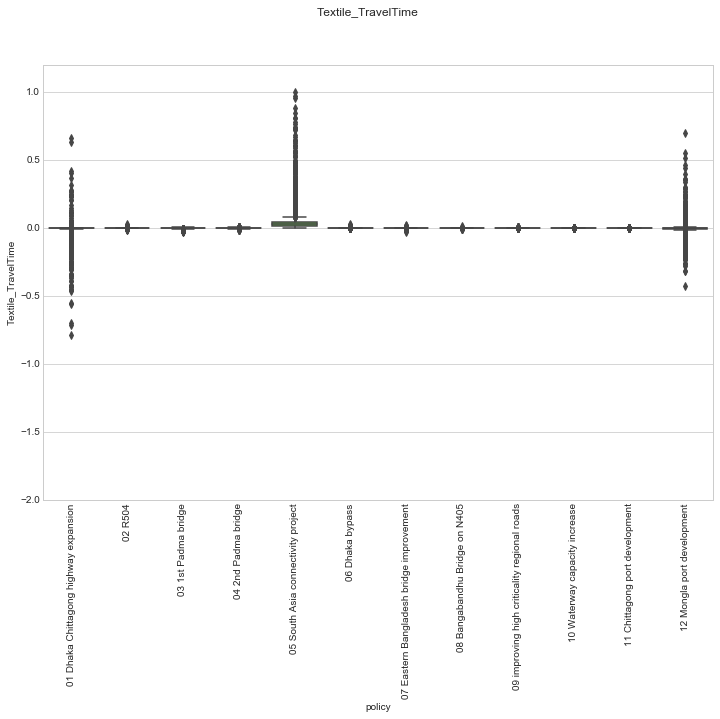

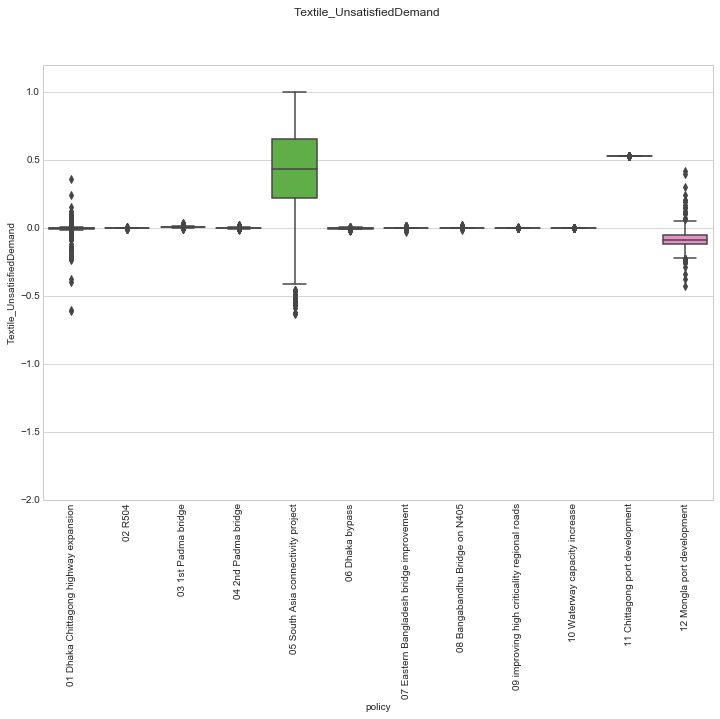

In [218]:
plotdata = reference_regret.copy()
policies = set(experiments['policy'])
policies.remove('no intervention')
policies = natsort.natsorted(policies)

maxima = plotdata.max()
plotdata = plotdata[sorted(plotdata.columns)]

for column in natsort.natsorted(plotdata.columns):
    data = plotdata[column]
    fig, ax = plt.subplots()
    fig.suptitle(column)
    data = data/maxima[column]
    data = data.reset_index(level=1)
    sns.boxplot(data=data, ax=ax, x='policy', y=column, order=policies)
    plt.xticks(rotation=90)
    ax.set_ylim(ymin=-2, ymax=1.2)
    plt.show()